In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder \
    .appName("count") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.memory", "1024M") \
    .getOrCreate()
sc = spark.sparkContext
df1 = spark.read.json("hdfs://localhost:9000/datasets/spotify/playlist.json")
df2 = spark.read.json("hdfs://localhost:9000/datasets/spotify/tracks.json")
df1.createOrReplaceTempView("playlist")
df2.createOrReplaceTempView("tracks")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-01-30 21:00:00,570 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-01-30 21:00:01,422 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df3 = spark.sql("select playlist.pid,playlist.num_tracks,tracks.artist_name from playlist,tracks where playlist.pid = tracks.pid")
df3.createOrReplaceTempView("temp")
df4 = spark.sql('''
select pid, artist_name, num_tracks, count from 
 (select *,
 row_number() over (partition by pid order by count desc) row_num 
 from 
 (Select pid, artist_name, num_tracks, count(*) count from temp group by 1,2,3) as t1 ) as t2 
 where row_num = 1
''')
df4.show(5)
n = df4.select("pid").summary("count").limit(1).first()["pid"]
print("n total = {0}".format(n))
df4.createOrReplaceTempView("final")

+---+---------------+----------+-----+
|pid|    artist_name|num_tracks|count|
+---+---------------+----------+-----+
|  0|Jesse McCartney|        52|    4|
|  6|        Misfits|        16|    3|
|  7|         Kiiara|        53|    2|
| 19|     Nick Drake|        85|    4|
| 22|           Russ|        42|    3|
+---+---------------+----------+-----+
only showing top 5 rows



n total = 161000


In [3]:
p_df = spark.sql("select count/num_tracks as p from final order by p").toPandas()

/tmp/ipykernel_181004/964205426.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0, 0.5, 'Cumulative Distribution Function')

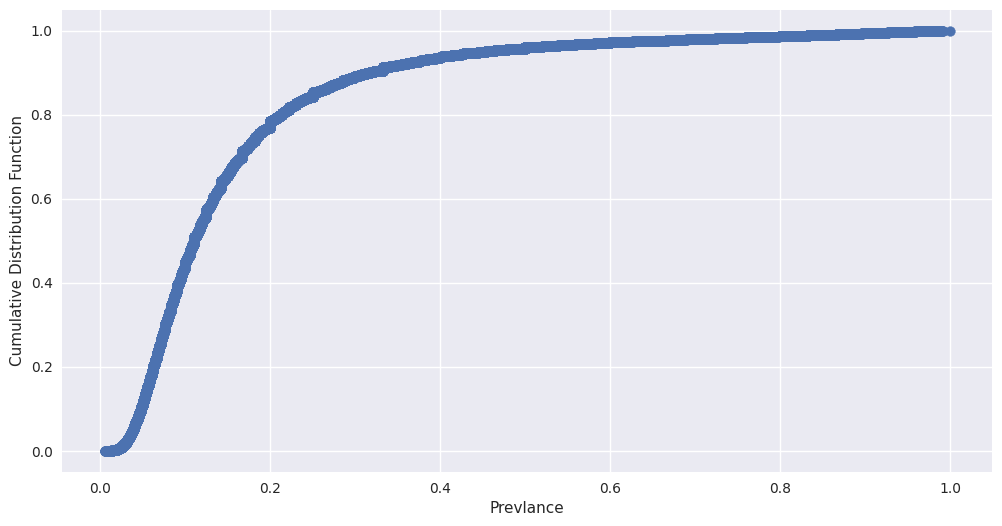

In [4]:
n = int(n)
x = p_df["p"]
y = [i/n for i in range(n)]
from matplotlib import pyplot as plt
plt.style.use("seaborn")
plt.figure(figsize=(12,6))
plt.scatter(x,y)
plt.xlabel("Prevlance")
plt.ylabel("Cumulative Distribution Function")